In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
M = 16
k = int(np.log2(M))
n = 1
TRAINING_SNR = 10
one_hot = False
sigma_pi = np.sqrt(0.02)

In [3]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(k/n)*ebno) 
    return noise_std

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [4]:
noise_std = EbNo_to_noise(TRAINING_SNR)

# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2*n]))
AWGN_channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

if one_hot:
    encoder_input = keras.layers.InputLayer(input_shape=[M])
else: 
    encoder_input = keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal', input_length=1)

encoder = keras.models.Sequential([
            encoder_input,
            keras.layers.Dense(M, activation="elu"),
            keras.layers.Dense(2*n, activation=None),
            shape_layer,
            norm_layer])

channel = keras.models.Sequential([AWGN_channel_layer])

decoder = keras.models.Sequential([
                keras.layers.InputLayer(input_shape=[2,n]),
                shape_layer2,
                keras.layers.Dense(M, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])


autoencoder = keras.models.Sequential([encoder, channel, decoder])

In [5]:
def policy_function(x_pert, x_enc):  
    x_scaled = x_enc*tf.cast(tf.sqrt(1.-sigma_pi**2), tf.float32)
    policy = -(1/sigma_pi**2)*tf.norm(x_pert - x_scaled, axis=1)**2
    #pulled the log inside, front factor vanishes for gradient
    #policy = (1./ (np.pi*(sigma_pi**2))**n)*tf.exp(-eu_norm / (sigma_pi**2))
    return policy

def perturbation(x):
    x_scaled = x * tf.cast(tf.sqrt(1-sigma_pi**2), tf.float32)
    z = tf.random.normal(tf.shape(x), mean=0.0, stddev=sigma_pi)
    return x_scaled + z

In [6]:
def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit/Symbol Error Rate'''
    batch_size = input_msg.shape[0]
    if one_hot:
        pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1)) 
    else:
        pred_error = tf.not_equal(tf.reshape(input_msg, shape=(-1,batch_size)), tf.argmax(msg, 1)) 
    
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

In [7]:
def random_sample(batch_size=32):
    if one_hot:
        msg = np.eye(M)[np.random.choice(M, batch_size)]
    else:
        msg = np.random.randint(M, size=(batch_size,1))
    
    return msg

In [8]:
def test_encoding(M=16, n=1):
    if one_hot:
        inp = np.eye(M)
    else:
        inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [9]:
def test_noisy_codeword(batch_size):
    X_batch  = random_sample(batch_size)
    x_enc = encoder(X_batch)
    y_recv = channel(x_enc)
    fig = plt.figure(figsize=(4,4))
    plt.plot(y_recv[:,0], y_recv[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plot_max = np.max(np.abs(y_recv))
    plt.gca().set_ylim(-plot_max, plot_max)
    plt.gca().set_xlim(-plot_max, plot_max)
    plt.show()

In [10]:
if one_hot:
    loss_fn = keras.losses.CategoricalCrossentropy()
    loss_fn_pE = keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
else:
    loss_fn_pE = keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    loss_fn = keras.losses.SparseCategoricalCrossentropy()

mean_loss = keras.metrics.Mean()

In [11]:
def plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding):
    template = 'Iteration: {}, Epoch: {}, Loss: {:.5f}, Batch_BER: {:.8f}'
    if step % 10 == 0:
        print(template.format(step, epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))
        if plot_encoding:
            test_encoding()

In [12]:
def plot_batch_loss(epoch, mean_loss, X_batch, y_pred):
        template_outer_loop = 'Interim result for Epoch: {}, Loss: {:.5f}, Batch_BER: {:.8f}'
        print(template_outer_loop.format(epoch, mean_loss.result(), B_Ber_m(X_batch, y_pred)))

In [13]:
def train_alternate( n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05, plot_encoding=False):
    optimizer_ae = keras.optimizers.Nadam(lr=learning_rate)
    mean_loss.reset_states()
    for epoch in range(1, n_epochs + 1): 
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs)) 
        for step in range(1, n_steps + 1):
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch)
                y_recv = channel(x_enc)
                y_pred = decoder(y_recv, training=True)
                loss_dec = loss_fn(X_batch, y_pred)
            gradients = tape.gradient(loss_dec, decoder.trainable_variables) 
            optimizer_ae.apply_gradients(zip(gradients, decoder.trainable_variables))
            #Draw another sample, as in the paper
            X_batch  = random_sample(batch_size)
            with tf.GradientTape() as tape:
                x_enc = encoder(X_batch, training=True)
                x_enc = shape_layer2(x_enc) #2*n
                x_pert = perturbation(x_enc)
                x_pert_s = shape_layer(x_pert)
                y_recv = channel(x_pert_s)
                y_pred = decoder(y_recv)
                loss = loss_fn_pE(X_batch, y_pred)
                #log already pulled inside the policy
                #stop_gradient enforces that x_pert and loss are seen as plain samples
                policy = policy_function(tf.stop_gradient(x_pert), x_enc)
                temp = tf.stop_gradient(loss)*tf.cast(policy, tf.float32)
                temp_avg = tf.reduce_mean(temp)
                grad_total = tape.gradient(temp_avg, encoder.trainable_variables)
                optimizer_ae.apply_gradients(zip(grad_total, encoder.trainable_variables))
                loss_cr = tf.reduce_mean(loss)
            mean_loss(loss_cr)
            plot_loss(step, epoch, mean_loss, X_batch, y_pred, plot_encoding)
        plot_batch_loss(epoch, mean_loss, X_batch, y_pred) 
        mean_loss.reset_states()

In [14]:
def Test_AE():
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):
        for it in range(1,1000):
            noise_std = EbNo_to_noise(snr_range[db])
            X_batch  = random_sample(500)
            code_word = encoder(X_batch)
            rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
            dcoded_msg = decoder(rcvd_word)
            bber = B_Ber_m(X_batch, dcoded_msg)
            bber_avg = mean_loss(bber)
        bber_vec[db] = bber_avg
        mean_loss.reset_states()
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

Training Bob in Epoch 1/2
Iteration: 10, Epoch: 1, Loss: 2.67962, Batch_BER: 0.79400003
Iteration: 20, Epoch: 1, Loss: 2.55553, Batch_BER: 0.66600001
Iteration: 30, Epoch: 1, Loss: 2.43203, Batch_BER: 0.64200002
Iteration: 40, Epoch: 1, Loss: 2.30580, Batch_BER: 0.61799997
Iteration: 50, Epoch: 1, Loss: 2.18748, Batch_BER: 0.44000000
Iteration: 60, Epoch: 1, Loss: 2.07940, Batch_BER: 0.46000001
Iteration: 70, Epoch: 1, Loss: 1.98402, Batch_BER: 0.40799999
Iteration: 80, Epoch: 1, Loss: 1.90022, Batch_BER: 0.38200000
Iteration: 90, Epoch: 1, Loss: 1.82596, Batch_BER: 0.29400000
Iteration: 100, Epoch: 1, Loss: 1.75625, Batch_BER: 0.25000000
Iteration: 110, Epoch: 1, Loss: 1.69157, Batch_BER: 0.24800000
Iteration: 120, Epoch: 1, Loss: 1.63077, Batch_BER: 0.20000000
Iteration: 130, Epoch: 1, Loss: 1.57382, Batch_BER: 0.23800001
Iteration: 140, Epoch: 1, Loss: 1.52026, Batch_BER: 0.22600000
Iteration: 150, Epoch: 1, Loss: 1.47057, Batch_BER: 0.19000000
Iteration: 160, Epoch: 1, Loss: 1.4237

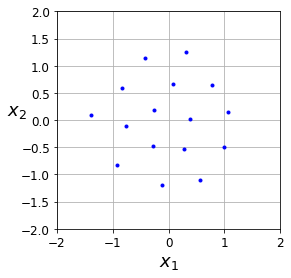

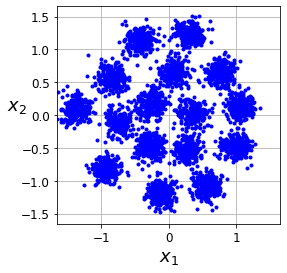

In [15]:
train_alternate(n_epochs=2, n_steps=400, batch_size=500, learning_rate=0.005,plot_encoding=False)

test_encoding(M, 1)

test_noisy_codeword(4000)

In [16]:
bber_data = Test_AE()

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


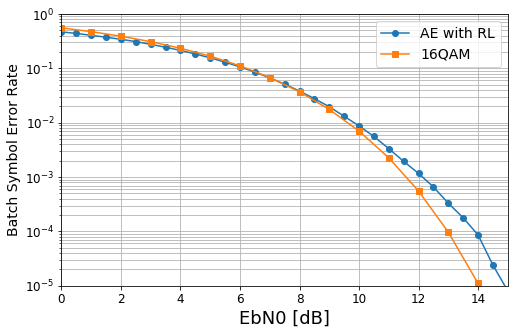

In [17]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))



ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(bber_data[0], bber_data[1], 'o-')

plt.plot(ebnodbs, SIXT_QAM_sim(ebnodbs), 's-')
    
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("EbN0 [dB]", fontsize=18)
plt.legend(['AE with RL', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")